# PROJET 4 : CONSOMMATION ELECTRIQUE DE BATIMENTS (Modélisation SiteEnergyUse)
*Mathieu GENTHON (avril-mai 2020)*

## SOMMAIRE<a class="anchor" id="sommaire"></a>
### 1 - [Contexte du projet](#1)<a class="anchor" id="sommaire"></a>
### 2 - [Importation des librairies et chargement dataframe](#2)<a class="anchor" id="sommaire"></a>
### 3 - [kNN](#3)<a class="anchor" id="sommaire"></a>
### 4 - [Régression linéaire](#4)<a class="anchor" id="sommaire"></a>
### 5 - [Régression Ridge](#5)<a class="anchor" id="sommaire"></a>
### 6 - [Régression LASSO](#6)<a class="anchor" id="sommaire"></a>
### 7 - [Régression Elastic Net](#7)<a class="anchor" id="sommaire"></a>
### 8 - [Random Forrest](#8)<a class="anchor" id="sommaire"></a>
### 9- [(X)GBoost](#9)<a class="anchor" id="sommaire"></a>
### 10- [Comparaison des modèles](#10)<a class="anchor" id="sommaire"></a>
### 11- [Export des prédictions](#11)<a class="anchor" id="sommaire"></a>

### 1 - [Contexte du projet](#1)<a class="anchor" id="1"></a>

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.

Problématique de la ville de Seattle

Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.
Votre mission :
- Réaliser une courte analyse exploratoire
- Tester différents modèles de prédiction pour répondre à la problématique

Quelques pistes, et erreurs à éviter :
L'objectif est de se passer des relevés de consommation annuels (attention à la fuite de données). Déduire des variables plus simples (nature et proportions des sources d'énergies utilisées) 
Faire attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).
Mettre en place une évaluation rigoureuse des performances de la régression et optimiser les hyperparamètres et le choix d'algorithme de ML à l'aide d'une validation croisée.

### 2 - [Importation des librairies et chargement dataframe](#2)<a class="anchor" id="2"></a>

In [517]:
# On importe les librairies dont on devrait avoir besoin pour le projet.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from sklearn import linear_model
from sklearn import model_selection
from sklearn import neighbors, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from pprint import pprint

%matplotlib inline
sns.set()
pd.set_option('display.max_columns', None) # On affiche toutes les colonnes des df
pd.options.display.max_rows = 100 # On affiche jusqu'à 100 lignes d'un df

In [518]:
# On charge les données depuis des fichiers en local et on crée des data frame pour chaque fichier.
path='C:/Users/GENTHON-M/Documents/formation/Open Classrooms/4-Consommation électrique de bâtiments/'
df_std_train = pd.read_csv(path+"df_std_train.csv")
df_std_test = pd.read_csv(path+"df_std_test.csv")
print( df_std_train.shape,df_std_test.shape)

(2238, 65) (960, 65)


In [520]:
def Calcul_Erreur(Y_test,y_pred):
    print("MAE : {:.4f}".format( np.mean(abs(y_pred-Y_test)) ))
    print("R-squared : {:.4f}".format (r2_score(Y_test,y_pred)))
    print("MSE : {:.4f}".format( metrics.mean_squared_error(Y_test, y_pred) ))
    print("RMSE : {:.4f}".format(np.sqrt( metrics.mean_squared_error(Y_test, y_pred) )))
    
def Return_Erreur(Y_test,y_pred):
    MAE =(np.mean(abs(y_pred-Y_test)) )
    #R_squared = (r2_score(Y_test,y_pred))
    MSE = (metrics.mean_squared_error(Y_test, y_pred) )
    RMSE = (np.sqrt( metrics.mean_squared_error(Y_test, y_pred) ))
    return ( MAE, MSE, RMSE)
#,R_squared

In [521]:
Input_Pred_To_Drop = ['SiteEnergyUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','SteamUse(kBtu)',\
             'TotalGHGEmissions','SiteEUI(kBtu/sf)','GHGEmissionsIntensity','ENERGYSTARScore',\
                     'RatioElec','RatioSteam','RatioGas'\
                     ]
#
X_train = df_std_train.drop(Input_Pred_To_Drop, axis=1)
X_test = df_std_test.drop(Input_Pred_To_Drop, axis=1)

Output = 'SiteEnergyUse(kBtu)'

Y_train = df_std_train.loc[:,Output].copy()
Y_test = df_std_test.loc[:,Output].copy()

In [522]:
X_train.shape

(2238, 54)

### 3 - [kNN](#3)<a class="anchor" id="3"></a>

In [523]:
from sklearn import neighbors, metrics

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 4, 5, 6, 7, 8, 9, 11, 13, 15]}

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée

clf = model_selection.GridSearchCV(
    neighbors.KNeighborsRegressor(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring='neg_mean_absolute_error' ,  # score à optimiser
    n_jobs=-1
)
# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train, Y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, params in zip(
        clf.cv_results_['mean_test_score'], # score moyen
        clf.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f}  for {}".format('MAE',-mean, params) )

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 8}
Résultats de la validation croisée :
MAE = 0.194  for {'n_neighbors': 3}
MAE = 0.191  for {'n_neighbors': 4}
MAE = 0.191  for {'n_neighbors': 5}
MAE = 0.191  for {'n_neighbors': 6}
MAE = 0.190  for {'n_neighbors': 7}
MAE = 0.189  for {'n_neighbors': 8}
MAE = 0.190  for {'n_neighbors': 9}
MAE = 0.191  for {'n_neighbors': 11}
MAE = 0.192  for {'n_neighbors': 13}
MAE = 0.192  for {'n_neighbors': 15}


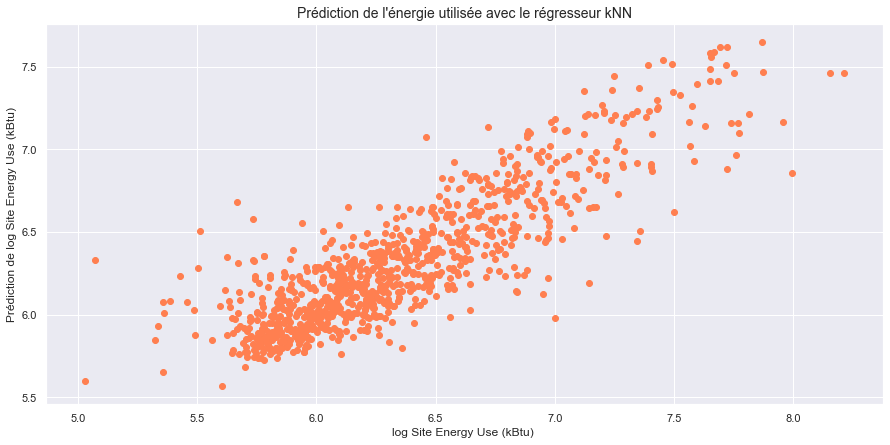

In [524]:
#ON prédit avec le meilleur classifieur.
y_pred = clf.predict(X_test)

Abs = "log Site Energy Use (kBtu) "
Ord = "Prédiction de log Site Energy Use (kBtu)"
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xlabel(Abs, fontsize = 12)
ax.set_ylabel(Ord, fontsize = 12)
plt.title( "Prédiction de l'énergie utilisée avec le régresseur kNN", fontsize = 14)
plt.scatter(Y_test, y_pred, color='coral')

In [525]:
Calcul_Erreur(Y_test,y_pred)

MAE : 0.1892
R-squared : 0.7343
MSE : 0.0677
RMSE : 0.2602


### 4 - [Régression linéaire](#4)<a class="anchor" id="4"></a>

In [526]:
lr = linear_model.LinearRegression()
lr.fit(X_train, Y_train)
y_pred_rli = lr.predict(X_test)

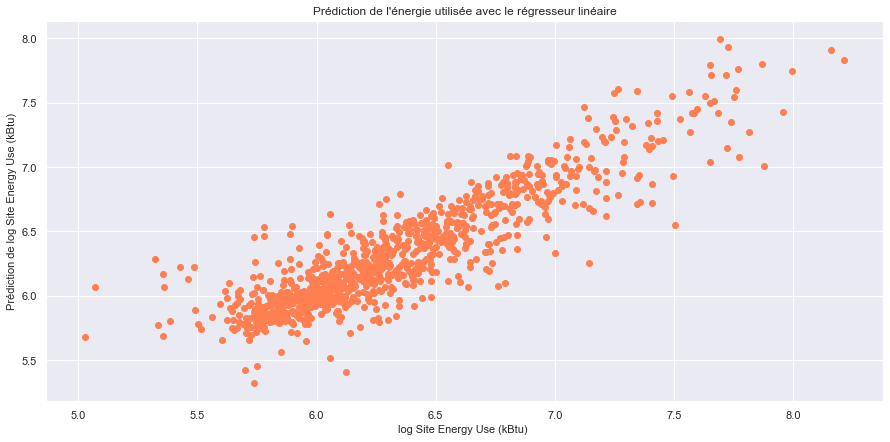

In [468]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xlabel(Abs, fontsize = 11)
ax.set_ylabel(Ord, fontsize = 11)
plt.title("Prédiction de l'énergie utilisée avec le régresseur linéaire", fontsize = 12)
plt.scatter(Y_test, y_pred_rli, color='coral')

In [427]:
Calcul_Erreur(Y_test,y_pred_rli)

MAE : 0.1576
R-squared : 0.8085
MSE : 0.0488
RMSE : 0.2210


### 5 - [Régression ridge](#5)<a class="anchor" id="5"></a>

In [428]:
# On récupère la MAE sur le jeu de données test comme baseline
baseline_error = np.mean(abs(y_pred_rli - Y_test))
print(baseline_error)

0.15763369776903957


In [429]:
ridge2 = linear_model.Ridge()
n_alphas = 100
alphas = np.logspace(-7, 5, n_alphas)
coefs = []
errors = []
for a in alphas:
    ridge2.set_params(alpha=a)
    ridge2.fit(X_train, Y_train)
    coefs.append(ridge2.coef_)
    errors.append([np.mean(abs(ridge2.predict(X_test) - Y_test))])

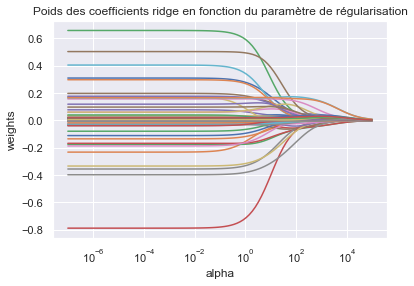

In [488]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Poids des coefficients ridge en fonction du paramètre de régularisation')
plt.axis('tight')
plt.show()

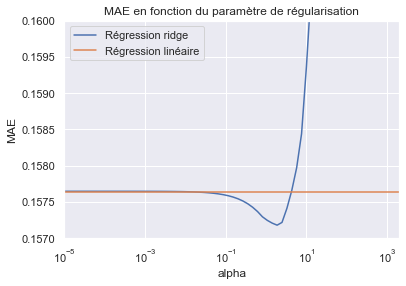

In [493]:
axes = plt.gca()
axes.plot(alphas, errors,[10**-8,10**5],[baseline_error,baseline_error])
axes.set_xscale('log')
plt.axis([0.00001,2000,0.157,0.160])
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.title('MAE en fonction du paramètre de régularisation')
plt.legend(['Régression ridge','Régression linéaire'])
plt.show()

In [432]:
min(errors)

[0.15717752024021017]

In [433]:
alphas[np.argmin(errors)]

1.8738174228603868

In [528]:
clf_rr = linear_model.RidgeCV(
    alphas=alphas,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring='neg_mean_absolute_error',   # score à optimiser
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf_rr.fit(X_train, Y_train)


# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) et alpha sur le jeu d'entraînement:")
print(clf_rr.alpha_, clf_rr.coef_)
y_pred_rr = clf_rr.predict(X_test)

Meilleur(s) hyperparamètre(s) et alpha sur le jeu d'entraînement:
0.6135907273413176 [ 0.28852469 -0.17636096 -0.17577651 -0.16749363  0.06671992  0.1842614
 -0.01987492 -0.34014617  0.10986035  0.36474816  0.0161162  -0.12409422
  0.61626185  0.00347337  0.12294575 -0.00948837  0.06584808 -0.03070294
  0.06757112 -0.01626012 -0.10032168  0.27944616 -0.07082168 -0.74202251
  0.17021153  0.49767267 -0.17139703 -0.38675896 -0.32214156 -0.02784099
  0.02047319  0.03078054  0.01343864  0.01826496  0.0072832  -0.00470589
 -0.02480947 -0.03229884  0.0330892  -0.02590393  0.00949761 -0.01726823
  0.03307838 -0.03307838  0.          0.09772453  0.15672266 -0.00686251
  0.00589982  0.16375055  0.02078906  0.16605254  0.01700136  0.01810554]


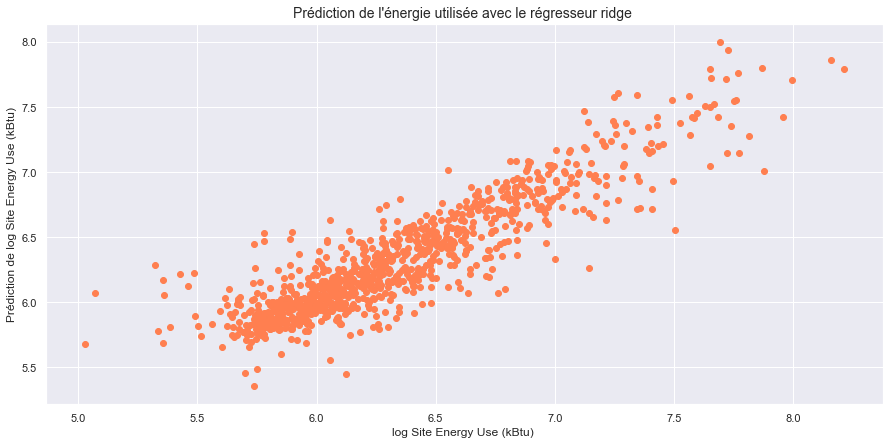

In [529]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xlabel(Abs, fontsize = 12)
ax.set_ylabel(Ord, fontsize = 12)
plt.title("Prédiction de l'énergie utilisée avec le régresseur ridge ", fontsize = 14)
plt.scatter(Y_test, y_pred_rr, color='coral')

In [530]:
Calcul_Erreur(Y_test,y_pred_rr)

MAE : 0.1574
R-squared : 0.8098
MSE : 0.0485
RMSE : 0.2202


### 6 - [Régression lasso](#6)<a class="anchor" id="6"></a>

In [531]:
from sklearn import model_selection
clf_lasso = linear_model.LassoCV(
    alphas=alphas,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    #scoring='neg_mean_absolute_error',
    #store_cv_values = True
    )

# Optimiser ce classifieur sur le jeu d'entraînement
clf_lasso.fit(X_train, Y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) et coefficient sur le jeu d'entraînement:")
print(clf_lasso.alpha_,clf_lasso.coef_)
y_pred_lasso = clf_lasso.predict(X_test)


Meilleur(s) hyperparamètre(s) et coefficient sur le jeu d'entraînement:
0.00014174741629268049 [ 0.30438489 -0.02921925 -0.13432214 -0.13846084  0.0896549   0.20463043
 -0.         -0.31949418  0.          0.36252505  0.02614306 -0.09984089
  0.63912026  0.          0.13183848 -0.          0.07547002 -0.01449534
  0.08150826 -0.         -0.06507368  0.27292675 -0.04928192 -0.73762047
  0.16196437  0.51153616 -0.14042099 -0.36965897 -0.30377098 -0.02908726
  0.01149702  0.01843811  0.00767261  0.01194728  0.         -0.0083443
 -0.02981789 -0.03415981  0.02469952 -0.02905606  0.         -0.01946498
  0.         -0.          0.          0.09524091  0.1567487  -0.00673547
  0.00603136  0.164186    0.0205687   0.16539799  0.01684044  0.01850097]


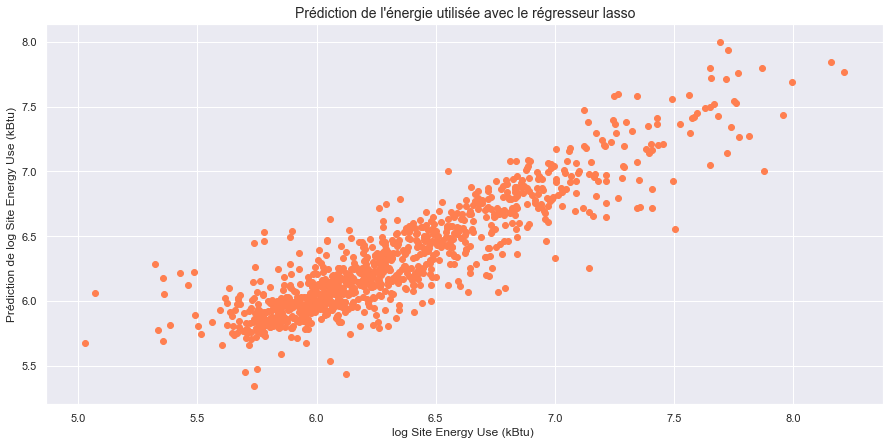

In [532]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xlabel(Abs, fontsize = 12)
ax.set_ylabel(Ord, fontsize = 12)
plt.title("Prédiction de l'énergie utilisée avec le régresseur lasso", fontsize = 14)
plt.scatter(Y_test, y_pred_lasso, color='coral')

In [478]:
Calcul_Erreur(Y_test,y_pred_lasso)

MAE : 0.1571
R-squared : 0.8106
MSE : 0.0483
RMSE : 0.2197


### 7 - [Régression elastic net](#7)<a class="anchor" id="7"></a>

In [533]:
clf_el_net = linear_model.ElasticNetCV(
    alphas=alphas,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1]
    #store_cv_values = True
    )

# Optimiser ce classifieur sur le jeu d'entraînement
clf_el_net.fit(X_train, Y_train)
y_pred_el_net = clf_el_net.predict(X_test)
# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement alpha et :")
print(clf_el_net.alpha_,clf_el_net.l1_ratio_)


C:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04658308760738805, tolerance: 0.04453788727153675
  tol, rng, random, positive)
C:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05016873875337069, tolerance: 0.04453788727153675
  tol, rng, random, positive)
C:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05382263422218614, tolerance: 0.04453788727153675
  tol, rng, random, positive)
C:\anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement alpha et :
0.0001873817422860385 0.7


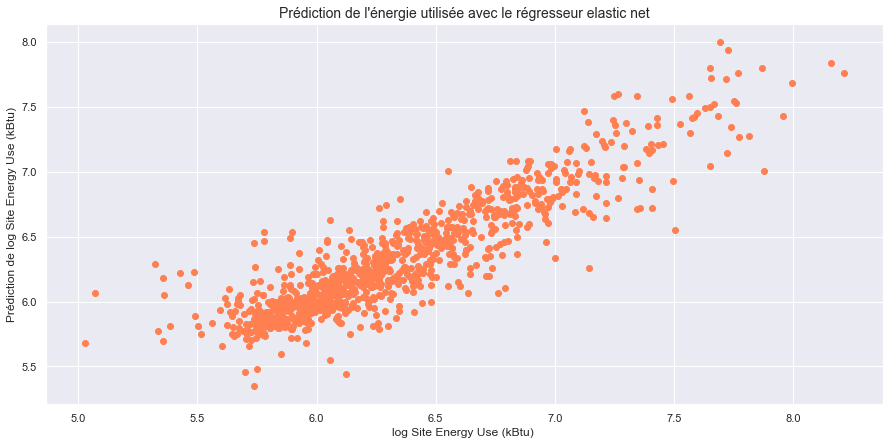

In [534]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xlabel(Abs, fontsize = 12)
ax.set_ylabel(Ord, fontsize = 12)
plt.title("Prédiction de l'énergie utilisée avec le régresseur elastic net", fontsize = 14)
plt.scatter(Y_test, y_pred_el_net, color='coral')

In [535]:
Calcul_Erreur(Y_test,y_pred_el_net)

MAE : 0.1571
R-squared : 0.8107
MSE : 0.0483
RMSE : 0.2197


### 8 - [Random forrest](#8)<a class="anchor" id="8"></a>

In [440]:
md = [i for i in range(4,40,3)]
mf = [j for j in range(7,30,2)]
parameters = {
    'max_depth': md,
    'max_features': mf,
             }

if __name__ == "__main__":

    clf_rfr = model_selection.GridSearchCV(RandomForestRegressor(),
                               parameters,
                               n_jobs=-1,
                               verbose=1,
                              scoring='neg_mean_absolute_error')

    print("Performing grid search...")
    print("parameters:")
    pprint(parameters)
    start_time = timeit.default_timer()
    clf_rfr.fit(X_train, Y_train)
    elapsed = timeit.default_timer() - start_time
    print("done in %0.3fs" % elapsed)
    print()

    print("Best score: %0.3f" % -clf_rfr.best_score_)
    print("Best parameters set:")
    best_parameters = clf_rfr.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
parameters:
{'max_depth': [4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37],
 'max_features': [7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]}
Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.4min finished


done in 82.287s

Best score: 0.157
Best parameters set:
	max_depth: 34
	max_features: 13


In [441]:
start_time = timeit.default_timer()
y_pred_fa = clf_rfr.predict(X_test)
elapsed = timeit.default_timer() - start_time

MAE = np.mean(abs(y_pred_fa-Y_test))
print("MAE {:.4f} time {:.2f}s".format(MAE, elapsed))

MAE 0.1588 time 0.03s


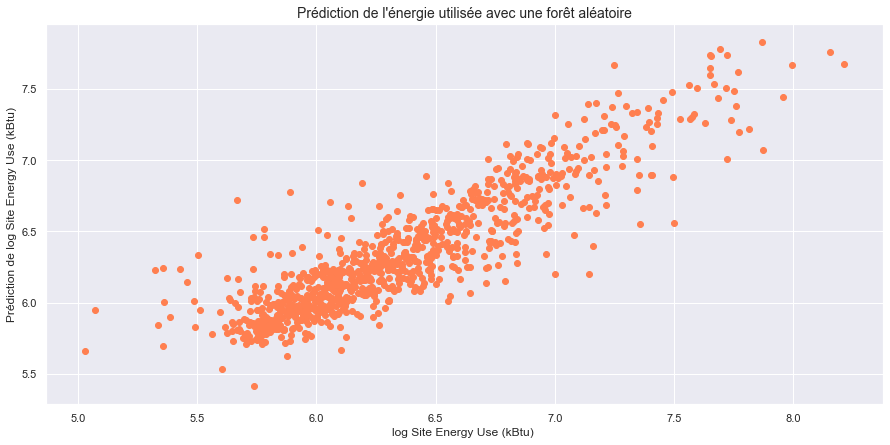

In [472]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xlabel(Abs, fontsize = 12)
ax.set_ylabel(Ord, fontsize = 12)
plt.title("Prédiction de l'énergie utilisée avec une forêt aléatoire", fontsize = 14)
plt.scatter(Y_test, y_pred_fa, color='coral')

In [443]:
Calcul_Erreur(Y_test,y_pred_fa)

MAE : 0.1588
R-squared : 0.7994
MSE : 0.0511
RMSE : 0.2261


In [444]:
#On sélectionne les features avec un poids supérieur au threshol de 0.003 pour améliorer le temps de calcul
rfr = RandomForestRegressor(max_depth = 18,max_features = 11)
rfr.fit(X_train, Y_train)

from sklearn.feature_selection import SelectFromModel
select = SelectFromModel(rfr, prefit=True, threshold=0.003)
X_train2 = select.transform(X_train)
X_test2 = select.transform(X_test)
print(X_train2.shape)

rfr2 = RandomForestRegressor(n_estimators=100, oob_score=True)
start_time = timeit.default_timer()
rfr2.fit(X_train2, Y_train)
pred = rfr2.predict(X_test2)
elapsed = timeit.default_timer() - start_time
MAE = np.mean(abs(pred-Y_test))

print("MAE {:.4f} time {:.2f}s".format(MAE, elapsed))

(2238, 28)
MAE 0.1612 time 1.14s


### 9 - [(X)GBoost](#9)<a class="anchor" id="9"></a>

In [536]:
md2 = [i for i in range(2,9)]
mf2 = [j for j in range(7,30,2)]
parameters = {
    'max_depth': md2,
    'max_features': mf2
             }

if __name__ == "__main__":

    clf_xgb = model_selection.GridSearchCV(GradientBoostingRegressor(),
                               parameters,
                               n_jobs=-1,
                               verbose=1,
                              scoring='neg_mean_absolute_error')

    print("Performing grid search...")
    print("parameters:")
    pprint(parameters)
    start_time = timeit.default_timer()
    clf_xgb.fit(X_train, Y_train)
    elapsed = timeit.default_timer() - start_time
    print("done in %0.3fs" % elapsed)
    print()

    print("Best score: %0.3f" % -clf_xgb.best_score_)
    print("Best parameters set:")
    best_parameters = clf_xgb.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
parameters:
{'max_depth': [2, 3, 4, 5, 6, 7, 8],
 'max_features': [7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]}
Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   19.8s finished


done in 20.097s

Best score: 0.155
Best parameters set:
	max_depth: 5
	max_features: 9


In [537]:
start_time = timeit.default_timer()
y_pred_xgb = clf_xgb.predict(X_test)
elapsed = timeit.default_timer() - start_time
MAE_XGB = np.mean(abs(y_pred_xgb-Y_test))
print("MAE {:.4f} time {:.2f}s".format(MAE_XGB, elapsed))

MAE 0.1540 time 0.01s


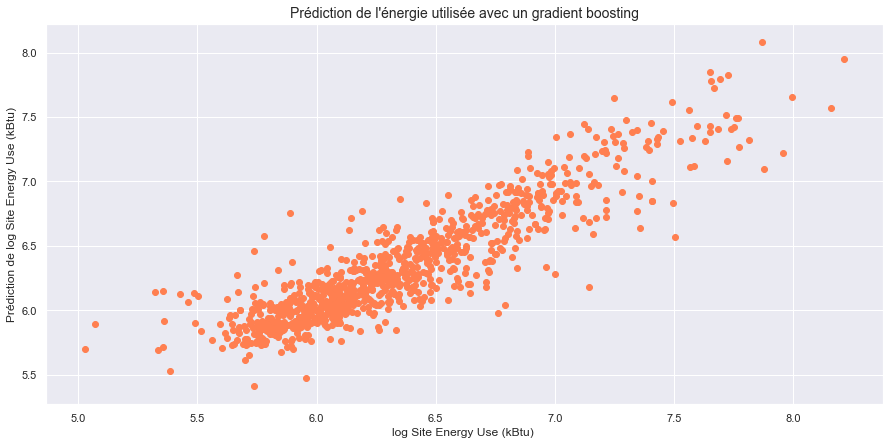

In [538]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xlabel(Abs, fontsize = 12)
ax.set_ylabel(Ord, fontsize = 12)
plt.title("Prédiction de l'énergie utilisée avec un gradient boosting", fontsize = 14)
plt.scatter(Y_test, y_pred_xgb, color='coral')

In [539]:
Calcul_Erreur(Y_test,y_pred_xgb)

MAE : 0.1540
R-squared : 0.8176
MSE : 0.0465
RMSE : 0.2157


In [540]:
#Feature Importance
xgb = GradientBoostingRegressor(max_depth=5,max_features=9)
xgb.fit(X_train, Y_train)
Val_feature_imp = xgb.feature_importances_
Feature = X_train.columns

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53],
 <a list of 54 Text yticklabel objects>)

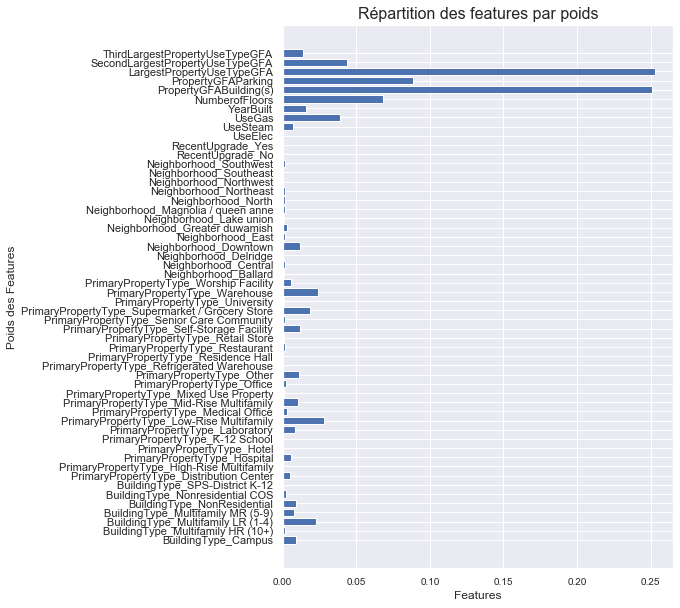

In [541]:
fig = plt.figure(figsize=(7,10))
axes = plt.axes()
axes.set_xlabel('Features', fontsize = 12)
axes.set_ylabel('Poids des Features', fontsize = 12)
#axes.set_ylim(0,1200)
plt.title('Répartition des features par poids', fontsize = 16)
plt.barh(Feature,Val_feature_imp)
plt.xticks(fontsize=10)
plt.yticks(fontsize=11)

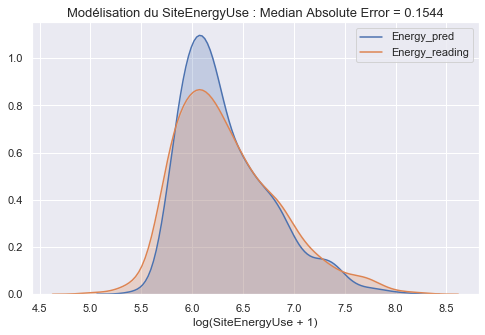

In [542]:
# Density plot
df_plot = pd.DataFrame({'Energy_pred':y_pred_xgb.tolist(), 'Energy_reading':Y_test.values.tolist()})
fig, ax = plt.subplots(figsize=(8,5))
sns.kdeplot(df_plot['Energy_pred'], shade=True, ax=ax)
sns.kdeplot(df_plot['Energy_reading'], shade=True, ax=ax)
ax.set_title('Modélisation du SiteEnergyUse : Median Absolute Error = 0.1544', fontsize=13)
ax.set_xlabel('log(SiteEnergyUse + 1)', fontsize=12)
plt.show()

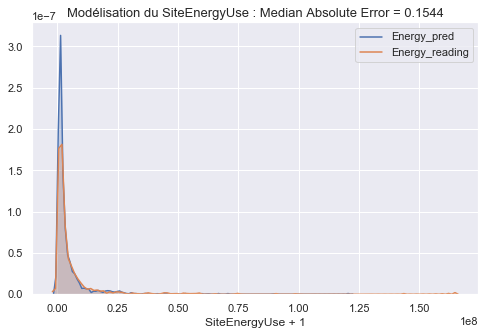

In [543]:
# Density plot
df_plot2 = pd.DataFrame({'Energy_pred':10**y_pred_xgb, 'Energy_reading':10**Y_test})
fig, ax = plt.subplots(figsize=(8,5))
sns.kdeplot(df_plot2['Energy_pred'], shade=True, ax=ax)
sns.kdeplot(df_plot2['Energy_reading'], shade=True, ax=ax)
ax.set_title('Modélisation du SiteEnergyUse : Median Absolute Error = 0.1544', fontsize=13)
ax.set_xlabel('SiteEnergyUse + 1', fontsize=12)
plt.show()

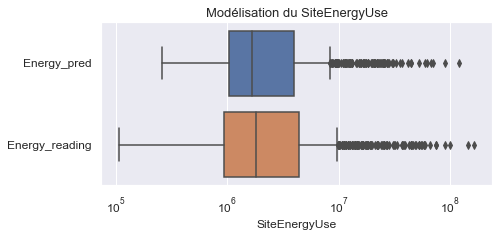

In [544]:
# Boxplot
fig, ax = plt.subplots(figsize=(7,3))
df_exp = pd.DataFrame({'Energy_pred':10**(y_pred_xgb)-1, 'Energy_reading':10**(Y_test)-1})
Erreur = Return_Erreur(10**(y_pred_xgb)-1, 10**(Y_test)-1)
bp = sns.boxplot(data=df_exp, orient='h')
ax.set_title('Modélisation du SiteEnergyUse', fontsize=13)
ax.set_xscale('log')
ax.tick_params(labelsize=12)
ax.set_xlabel('SiteEnergyUse', fontsize=12)
plt.show()


In [545]:
Calcul_Erreur(10**(y_pred_xgb)-1, 10**(Y_test)-1)

MAE : 2204413.2137
R-squared : 0.2344
MSE : 55252970089235.4297
RMSE : 7433234.1608


In [546]:
from scipy import stats
print(np.mean(10**(Y_test)-1))

5332724.613764789


In [547]:
#Sauvegarde du modèle : 
import pickle
pickle.dump(xgb, open(path+'xgb_energy.sav', 'wb'))

### 10 - [Comparaison des modèles](#10)<a class="anchor" id="10"></a>

In [548]:
kNN_result = Return_Erreur(Y_test,y_pred)
regLin_result = Return_Erreur(Y_test,y_pred_rli)
regrid_result = Return_Erreur(Y_test,y_pred_rr)
regLas_result = Return_Erreur(Y_test,y_pred_lasso)
regElNt_result = Return_Erreur(Y_test,y_pred_el_net)
RdmFo_result = Return_Erreur(Y_test,y_pred_fa)
XGbst_result = Return_Erreur(Y_test,y_pred_xgb)

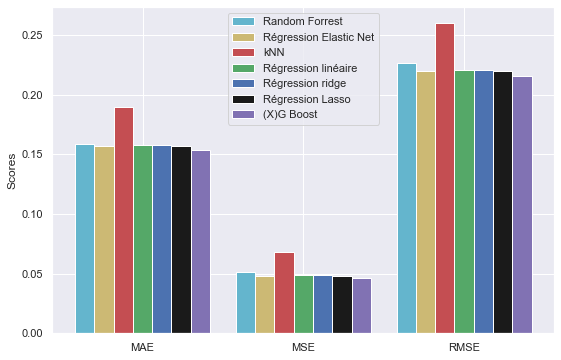

In [549]:
import numpy as np
import matplotlib.pyplot as plt

N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.12       # the width of the bars

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot()

rects1 = ax.bar(ind, kNN_result, width, color='r')
rects2 = ax.bar(ind+width, regLin_result, width, color='g')
rects3 = ax.bar(ind+width*2, regrid_result, width, color='b')
rects4 = ax.bar(ind+width*3, regLas_result, width, color='k')
rects5 = ax.bar(ind-width, regElNt_result, width, color='y')
rects6 = ax.bar(ind-width*2, RdmFo_result, width, color='c')
rects7 = ax.bar(ind+width*4, XGbst_result, width, color='m')

ax.set_ylabel('Scores')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('MAE', 'MSE','RMSE') )
ax.legend( (rects6[0],rects5[0],rects1[0], rects2[0], rects3[0], rects4[0],rects7[0]), \
          ('Random Forrest','Régression Elastic Net','kNN', 'Régression linéaire', 'Régression ridge','Régression Lasso',\
           '(X)G Boost') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/6., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

plt.show()


### 11 - [Export des prédictions](#11)<a class="anchor" id="11"></a>

In [550]:
Site_Enegery_Pred = pd.DataFrame(y_pred_xgb, columns = ['SiteEnergy_Prediction'])
Site_Enegery_Pred.to_csv(path+"Site_Enegery_Pred.csv",index=False, sep=',', encoding='utf-8')
Site_Enegery_Pred

,SiteEnergy_Prediction
0,6.198265
1,6.036052
2,6.727302
3,6.013323
4,6.822900
...,...
955,7.264052
956,5.931757
957,6.274433
958,5.693952
